In [2]:
import googlemaps
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import datetime as dt
import pytz
import pickle
from pprint import pprint
import seaborn as sns

In [3]:
def open_read( file_name, mode = '', df = ''):
        if mode == 'w':
                with open('data/'+file_name, 'wb') as f:
                    pickle.dump(df, f)
        elif mode =='r':
                with open('data/'+file_name, 'rb') as f:
                    df = pickle.load(f)                
                return df

df = open_read('0.03_intermediate', mode = 'r')

#  Sample trips

In [4]:
descriminant_series = (df.trip_duration > 90) & (df.usertype == 'Customer') & (df.ss_id != df.es_id)
df_sampled = df.loc[descriminant_series].sample(n=200)
df_sampled.head(2)

,trip_duration,starttime,stoptime,ss_id,ss_name,ss_lat,ss_lon,es_id,es_name,es_lat,...,age,starttime_hour,starttime_month,starttime_dayofweek,stoptime_hour,stoptime_month,stoptime_dayofweek,stations_distance,route,trip_eff_speed
166509,1115,2018-09-03 21:08:49.527,2018-09-03 21:27:25.375,312,Allen St & Stanton St,40.722055,-73.989111,455,1 Ave & E 44 St,40.750020,...,49,21,9,0,21,9,0,3537.591307,312_455,1.121877
164043,1918,2018-08-03 14:12:40.532,2018-08-03 14:44:38.984,3461,Murray St & Greenwich St,40.714852,-74.011223,232,Cadman Plaza E & Tillary St,40.695977,...,49,14,8,4,14,8,4,2750.465915,3461_232,1.088184


# Get utc unix times for query

In [5]:
def get_unix_time(timestamp):
    est = pytz.timezone('US/Eastern')
    utc = pytz.utc
    loc_time = est.localize(pd.to_datetime(timestamp))
    #print(loc_time, loc_time.dayofweek, loc_time.hour)
    day_of_week =  est.localize(pd.to_datetime(timestamp)).dayofweek
    hour =  est.localize(pd.to_datetime(timestamp)).hour

    future_biased_query_date = est.localize(dt.datetime(2019,9,2,0,0,0)+\
                                            dt.timedelta(hours = hour, days = day_of_week))
    #print(future_biased_query_date)
    future_biased_query_date = future_biased_query_date.astimezone(utc)
    #print(future_biased_query_date.timestamp())
    return int(future_biased_query_date.timestamp())

df_sampled['utc_unix_starttime'] = df_sampled['starttime'].apply(lambda x: get_unix_time(x))

#  Get query data

In [6]:
def get_api_query_data(df):
    data = {}
    for index, row in df.iterrows():
        data[index] = (row.ss_lat,row.ss_lon, row.es_lat, row.es_lon, row.utc_unix_starttime)           
    return data

api_query_data = get_api_query_data(df_sampled)

#  Perform api query

In [7]:
API_key = API_KEY # enter an google maps api key
gmaps = googlemaps.Client(key=API_key)

def query_api(row,data, mode = '', transit_mode = ''):
    index = row.name
    origins = '"'+str(data[index][0])+', '+str(data[index][1])+'"'
    destinations = '"'+str(data[index][2])+', '+str(data[index][3])+'"'
    time_of_travel = data[index][4]
    x = gmaps.distance_matrix(origins=origins ,destinations = destinations,
                                 departure_time = time_of_travel , mode = mode, transit_mode = transit_mode)
    if mode == 'driving':
        return x['rows'][0]['elements'][0]['duration_in_traffic']['value']
    
    if mode == 'transit':
        return x


#df['trip_duration_transit'] = df_sampled.apply(lambda x: query_api(x, api_query_data, mode = 'transit'), axis = 1)
df_sampled['trip_duration_car'] = df_sampled.apply(lambda x: query_api(x, api_query_data, mode = 'driving'), axis = 1)

In [13]:
open_read('200_trips_with_api_data.pkl', mode = 'w', df = df)

#  Visualize results

In [8]:
print(df_sampled.trip_duration.describe())
print(df_sampled.trip_duration_car.describe())

count      200.000000
mean      1609.350000
std       1740.535864
min        276.000000
25%        797.500000
50%       1284.500000
75%       1630.500000
max      14924.000000
Name: trip_duration, dtype: float64
count     200.000000
mean      724.490000
std       399.802049
min       117.000000
25%       459.000000
50%       640.000000
75%       916.000000
max      2866.000000
Name: trip_duration_car, dtype: float64


#  Get duration deltas and duration categories

In [21]:
df_sampled['delta'] = (df_sampled['trip_duration'] - df_sampled['trip_duration_car'])/60
df_sampled['Duration_class'] = pd.cut(df_sampled['trip_duration'], bins = (0,600, 1200,1800, 99999),
                                      labels = ['very short', 'short', 'medium', 'long'])
duration_delta_groups = df_sampled.groupby('Duration_class')['delta'].median().reset_index()
print(df_sampled.delta.describe([.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.99]))
duration_delta_groups

count    200.000000
mean      14.747667
std       29.042145
min      -13.116667
1%        -7.900667
5%        -1.557500
10%        0.085000
20%        2.460000
30%        4.278333
40%        6.373333
50%        7.858333
60%        9.753333
70%       12.398333
80%       18.000000
90%       26.110000
95%       44.493333
99%      118.681667
max      239.200000
Name: delta, dtype: float64


,Duration_class,delta
0,very short,0.841667
1,short,5.208333
2,medium,10.800000
3,long,23.675000


In [ ]:
df_sampl

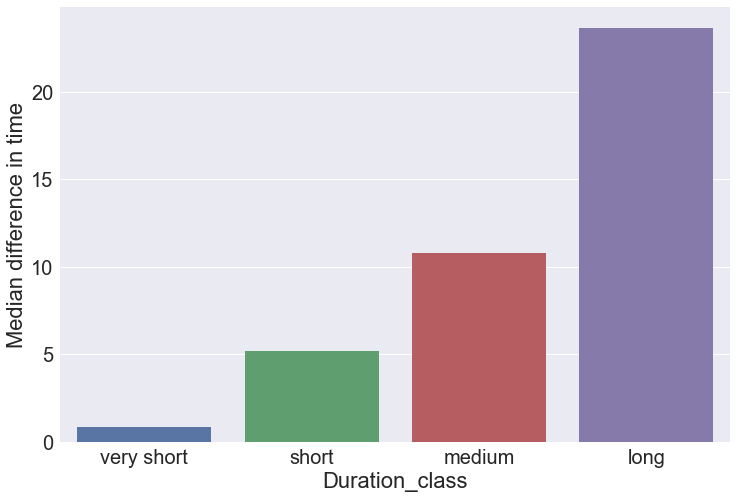

In [17]:
fig, ax = plt.subplots(figsize = (12,8))
sns.set(font_scale=1.5)
sns.barplot(x='Duration_class', y='delta', data=duration_delta_groups)
ax.set_ylabel('Median difference in time')
plt.show()